In [1]:
# Import libraries
import pystan # install with pip install pystan
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import beta
import matplotlib.pyplot as plt
import pickle
import hashlib
import time

def get_stan_model(code):
    code_hash = hashlib.sha1(code.encode('utf-8')).hexdigest()
    cache_path =  './cache/' + code_hash + '.pkl'
    try:
        with open(cache_path, 'rb') as file:
            model = pickle.load(file)
    except Exception:
        model = pystan.StanModel(model_code=code) ## c로 변환
        with open(cache_path, 'wb') as file:

            pickle.dump(model, file)
    return model

In [ ]:
### 활용팁
- parameter summary
params.summary().keys()

#매개변수 여러개인 경우 슬라이싱 통해 가능
np.median(params.summary()['summary'][:100, 0])

#설명
help(pystan.StanModel.sampling, alg)

## 5.1 중회귀

A: 아르바이트 선호 여부(0: 좋아하지 않음, 1: 좋아함)

Score: 학문 흥미도 수치화(200만점)

Y: 1년간 출석률

In [3]:
#data
df = pd.read_csv('data/data-attendance-1.txt')

#model
model_5_3 ='''
data {
    int N;
    real A[N];
    real Score[N];
    real Y[N];
}

parameters {
    real b[3];
    real <lower = 0> sigma;
}

transformed parameters {
    real mu[N];
    for (n in 1:N)
        mu[n] = b[1] + b[2] * A[n] + b[3] * Score[n];
}

model {
    for (n in 1:N)
        Y[n] ~ normal(mu[n], sigma);
}
        
generated quantities {
    real y_pred[N];
    for (n in 1:N){
        y_pred[n] = normal_rng(mu[n], sigma);
    }
}

'''

#python interface

data = {
    'N': df.shape[0],
    'A' : df.iloc[:,0],
    'Score' : df.iloc[:,1],
    'Y' : df.iloc[:,2],
}

#result
model_5_3 = get_stan_model(model_5_3)
params = model_5_3.sampling(data = data)

#stan의 indexing은 1부터 시작하므로 유의하자

독립, 종속변수를 벡터화

In [33]:
#data
df = pd.read_csv('data/data-attendance-1.txt')

#model
model_5_3 ='''
data {
    int N;
    vector[N] A;
    vector[N] Score;
    vector[N] Y;
}

parameters {
    real b[3];
    real <lower = 0> sigma;
}

transformed parameters {
    vector[N] mu;
        mu = b[1] + b[2] * A + b[3] * Score;
}

model {

    Y ~ normal(mu, sigma);
}

'''

#python interface
data = {
    'N': df.shape[0],
    'A' : df.iloc[:,0],
    'Score' : df.iloc[:,1],
    'Y' : df.iloc[:,2],
}
#result
model_5_3 = get_stan_model(model_5_3)
params = model_5_3.sampling(data = data)

## 5.2 Binomial Logistics regression

personID: ID

M: 3개월 과정으로 등록한 과목의 총 수업 횟수, 

Y: 실제 출석 횟수

출석이라는 사건이 전체 수업일수 중 p의 확률로 발생하는 이항분포를 따른다고 가정

In [7]:
#data
df = pd.read_csv('data/data-attendance-2.csv')

In [8]:
df['ratio'] = df['Y'] / df['M']

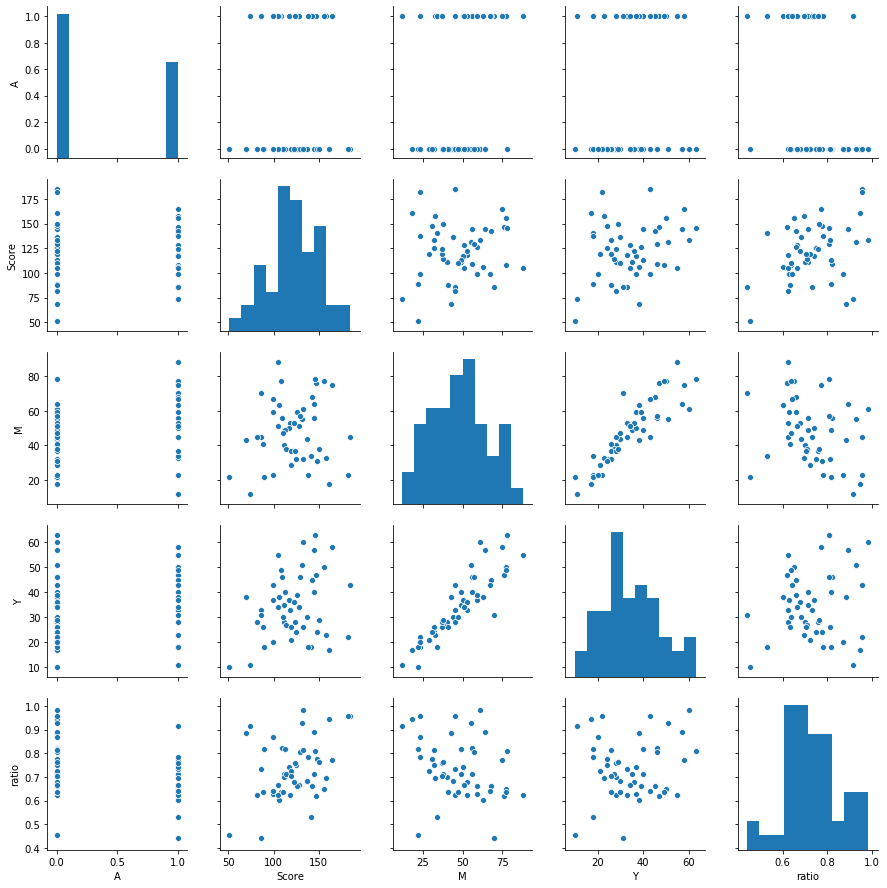

In [9]:
sns.pairplot(data = df.iloc[:, 1:])

In [21]:
#data
df = pd.read_csv('data/data-attendance-2.csv')

#model
model_5_4 ='''
data {
    int N;
    vector <lower = 0, upper =1>[N] A;
    vector <lower = 0, upper =1>[N] Score;
    int <lower = 0> M[N];
    int <lower = 0> Y[N];
}


parameters {
    real b[3];
    real <lower = 0> sigma;
}

model {

    Y ~ binomial_logit(M, b[1] + b[2] * A + b[3] * Score);
}

'''
norm_score = df.iloc[:,1]/max(df.iloc[:,1])
#python interface
data = {
    'N': df.shape[0],
    'A' : df.iloc[:,1],
    'Score' : norm_score,
    'M' : df.iloc[:,2],
    'Y' : df.iloc[:,3],
}
#result
model_5_4 = get_stan_model(model_5_4)
params = model_5_4.sampling(data = data)

# 1.vector선언시 순서: 모수제약(범위) -> vector 크기
# 2. Y는 이항분포의 결과로 int형이므로 vector로 선언이 불가하다

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be2a18c3c6c890ec37f5889c8cbc652d NOW.


## 5.3 logistic regression

1.데이터의 형태가 한 row가 ID기준의 집계값이었다면, 여기선 출석 1회 사건 

-> 데이터 개수 변수가 N에서 I가 됨
-> y가 출석횟수에서 출석여부로 바뀌면서 이항분포가 베르누이 분포가 됨

2. 이산값(문자열)데이터이 날씨가 출석에 영향미침 -> 수치화

In [47]:
# read data
df = pd.read_csv('data/data-attendance-3.txt')


#model
model_5_5 ='''
data {
    int N;
    vector <lower = 0, upper =1>[N] A;
    vector <lower = 0, upper =1>[N] Score;
    real <lower = 0> W[N];
    int <lower = 0> Y[N];
}


parameters {
    real b[3];
    real <lower = 0> sigma;
}

model {

    Y ~ bernoulli_logit(b[1] + b[2] * A + b[3] * Score);
}

'''
label = {'A': 0, 'B': 0.2,'C': 1}

norm_score = df.iloc[:,1]/max(df.iloc[:,1])
#python interface
data = {
    'N': df.shape[0],
    'A' : df.iloc[:,1],
    'Score' : norm_score,
    'W' : df.iloc[:,3].apply(lambda x: label[x]),
    'Y' : df.iloc[:,4],
}
#result
model_5_5 = get_stan_model(model_5_5)
params = model_5_5.sampling(data = data)

## 5.4 poisson regression

전체 수업횟수 M과 A와 Score의 영향관계 파악?

전체 수업횟수 M과 같이 값이 이산형, 0이상인 경우는 poisson regression

In [6]:
#data
df = pd.read_csv('data/data-attendance-2.csv')

#model
model_5_6 ='''
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
  real lambda[N];
    lambda[n] = exp(b[1] + b[2]*A[n] + b[3]*Score[n]);
}

model {
  for (n in 1:N)
    M[n] ~ poisson(lambda[n]);
}

generated quantities {
  int m_pred[N];
  for (n in 1:N)
    m_pred[n] = poisson_rng(lambda[n]);
}

'''
#python interface
data = {
    'N': df.shape[0],
    'A' : df.iloc[:,0],
    'Score' : norm_score,
    'M' : df.iloc[:,2],
}

model_5_6 = get_stan_model(model_5_6)
params = model_5_6.sampling(data = data)

In [49]:
#data
df = pd.read_csv('data/data-attendance-2.csv')

#model
model_5_6 ='''
data {
  int N;
  vector<lower=0, upper=1>[N] A;
  vector <lower=0, upper=1>[N] Score;
  int <lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
    vector[N] lambda;
    lambda = exp(b[1] + b[2]*A + b[3]*Score);
}

model {
    M ~ poisson(lambda);
}

generated quantities {
  int m_pred[N];
  m_pred = poisson_rng(lambda);
}

''' 
norm_score = df.iloc[:,2]/max(df.iloc[:,2])

#python interface
data = {
    'N': df.shape[0],
    'A' : df.iloc[:,1],
    'Score' : norm_score,
    'M' : df.iloc[:,2],
}

model_5_6 = get_stan_model(model_5_6)
params = model_5_6.sampling(data = data)

앞서 이항분포에서 Y가 int값이기에 벡터형 선언불가했던 이유와 마찬가지 이유로 다음과 같은 코드는 에러다. stan은 형에 비교적 엄격하다.
<pre><code>
data {
  int N;
  vector<lower=0, upper=1>[N] A;
  vector <lower=0, upper=1>[N] Score;
  vector <lower=0>[N] M;
}

parameters {
  real b[3];
}

transformed parameters {
    vector[N] lambda;
    lambda = exp(b[1] + b[2]*A + b[3]*Score);
}

model {
    M ~ poisson(lambda);
}
</pre></code>



In [52]:
params


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_a0f90fad1234a8ae11ec96882e9d416f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         3.76  1.7e-3   0.06   3.64   3.72   3.77   3.81   3.89   1361    1.0
b[2]       7.8e-3  6.4e-4   0.03  -0.04  -0.01 7.9e-3   0.03   0.06   1727    1.0
b[3]         1.53  2.4e-3   0.09   1.36   1.47   1.53   1.59   1.71   1317    1.0
lambda[1]   76.42    0.06   2.47  71.67  74.73  76.41  78.07  81.32   1492    1.0
lambda[2]   144.4    0.07    3.2 138.13 142.25 144.41 146.53 150.65   2101    1.0
lambda[3]  121.41    0.04   2.04  117.3 120.07 121.42 122.79 125.35   2626    1.0
lambda[4]   88.64    0.06   2.51  83.84  86.91  88.61   90.3  93.62   1707    1.0
lambda[5]  160.81    0.09   4.04 152.81 158.12 160.76 163.49 168.86   1831    1.0
lambda[6]  129.72    0.04   2.19 